# Comparison between Tikhonov extraction and classic box extraction
- simulation without tilt (so box extraction not disadvantaged)
- Constant throughtput

# Imports

## For plots

In [37]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

## Imports from standard packages

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.io import fits

## Local imports

In [2]:
from overlap import TrpzOverlap
from classic import OptimalExtract
from utils import get_soss_grid
from throughput import ThroughputSOSS

# Read ref files

In [4]:
# Read relevant files
wv_1 = fits.open("Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("Ref_files/wavelengths_m2.fits")[0].data
P1 = fits.open("Ref_files/spat_profile_m1.fits")[0].data.squeeze()
P2 = fits.open("Ref_files/spat_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

# Remove the tilt from wv maps
wv_1 = np.tile(wv_1[50,:], (256, 1))
wv_2 = np.tile(wv_2[50,:], (256, 1))

# Setup for simulation

## Wavelength grid

In [5]:
lam_simu = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=15)

## Initiate a simulation.

In [6]:
# Choose a small threshold for the spatial profile cut
# (less than for a normal extraction)
simu = TrpzOverlap([P1,P2], [wv_1,wv_2], lam_grid=lam_simu, thresh=1e-8, c_kwargs={'thresh':1e-5})

# ***** WARNING *******
# Since it's oversampled, may take some time to initiate
# (mostly because of the convolution matrix)

## Save the injected flux at each resulution

In [11]:
# Compute injected convolved flux for each orders
f_th_c = [interp1d(simu.lam_grid_c(i_ord),
                   simu.c_list[i_ord].dot(flux),
                   kind='cubic', fill_value="extrapolate")
          for i_ord in range(2)]

# Case 1: Sinus function

## Inject sinus

In [9]:
# Generate flux to inject
flux = 1 + 0.5 * np.sin(lam_simu*500)
# Multiplication by a fudge factor to get
# a realistic number of counts on the detector
flux *= 1e12
# flux *= 1e9

# Inject order 1 and 2 separately (we don't want any contamination here)
data1 = simu.rebuild(flux, orders=[0])
data2 = simu.rebuild(flux, orders=[1])

## Extraction with Tikhonov

### Build tikhonov matrix

In [32]:
from utils import grid_from_map, oversample_grid
from convolution import get_c_matrix, WebbKer
from scipy.sparse import identity

class TikhoConvMatrix:
    """
    Convolution matrix to be used as
    Tikhonov regularisation matrix.
    This way, the solution of the system can be 
    deviated towards solutions closed to a solution
    at a resolution close to `n_os` times the resolution
    given by the `wv_map`.
    """
    
    def __init__(self, wv_map, psf, n_os=2, thresh=1e-5):

        # Save attributes
        self.wv_map = wv_map
        self.psf = psf
        self.n_os = n_os
        self.thresh = thresh
        
    def __call__(self, grid):
        
        # Get needed attributes
        gargs = ['wv_map', 'psf', 'n_os', 'thresh']
        wv_map, psf, n_os, thresh = self.getattrs(*gargs)

        # Generate a fake wv_map to cover all wv_range with a
        # resolution `t_mat_n_os` times the resolution
        # of wv_map (generally order 2).
        wv_range = [grid.min(), grid.max()]
        wv_map = grid_from_map(wv_map, psf, wv_range=wv_range)
        wv_map = oversample_grid(wv_map, n_os=n_os)
        # Build convolution matrix
        conv_ord2 = get_c_matrix(WebbKer(wv_map[None, :]),
                                 grid, thresh=thresh)
        # Build tikhonov matrix
        t_mat = conv_ord2 - identity(conv_ord2.shape[0])

        return t_mat
    
    def getattrs(self, *args):
        """
        Return list of attributes

        Parameters
        ----------
        args: str
            All attributes to return.
        """
        return [getattr(self, arg) for arg in args]


In [16]:
# Parameters for extraction
n_os = 4
c_thresh = 1e-5
t_mat_n_os = 2

In [33]:
tikho_matrix = TikhoConvMatrix(wv_2, P2, n_os=t_mat_n_os, thresh=c_thresh)

### Extract

In [41]:
lam_grid = grid_from_map(wv_1, P1)
lam_grid = oversample_grid(lam_grid, n_os=n_os)
extra = TrpzOverlap([P1], [wv_1], scidata=data1,
                    lam_grid=lam_grid, thresh=1e-5,
                    c_kwargs={'thresh': c_thresh}, orders=[1])

In [49]:
factors = 10.**(-1*np.arange(12, 20, 0.3))
extra.get_tikho_tests(factors, t_mat=tikho_matrix(lam_grid))

Testing factors...
27/27


{'factors': array([1.00000000e-12, 5.01187234e-13, 2.51188643e-13, 1.25892541e-13,
        6.30957344e-14, 3.16227766e-14, 1.58489319e-14, 7.94328235e-15,
        3.98107171e-15, 1.99526231e-15, 1.00000000e-15, 5.01187234e-16,
        2.51188643e-16, 1.25892541e-16, 6.30957344e-17, 3.16227766e-17,
        1.58489319e-17, 7.94328235e-18, 3.98107171e-18, 1.99526231e-18,
        1.00000000e-18, 5.01187234e-19, 2.51188643e-19, 1.25892541e-19,
        6.30957344e-20, 3.16227766e-20, 1.58489319e-20]),
 'solution': array([[ 1.13376636e+12,  1.12980160e+12,  1.13309058e+12, ...,
          1.52632202e+12,  1.52789706e+12,  1.52455867e+12],
        [ 1.13353667e+12,  1.12956471e+12,  1.13286617e+12, ...,
          1.52751206e+12,  1.52901628e+12,  1.52569302e+12],
        [ 1.13347800e+12,  1.12950420e+12,  1.13280887e+12, ...,
          1.52862238e+12,  1.53005080e+12,  1.52674644e+12],
        ...,
        [-1.57240261e+15,  3.47565044e+14, -9.04523179e+14, ...,
          2.86835854e+21, -3.67

<IPython.core.display.Javascript object>


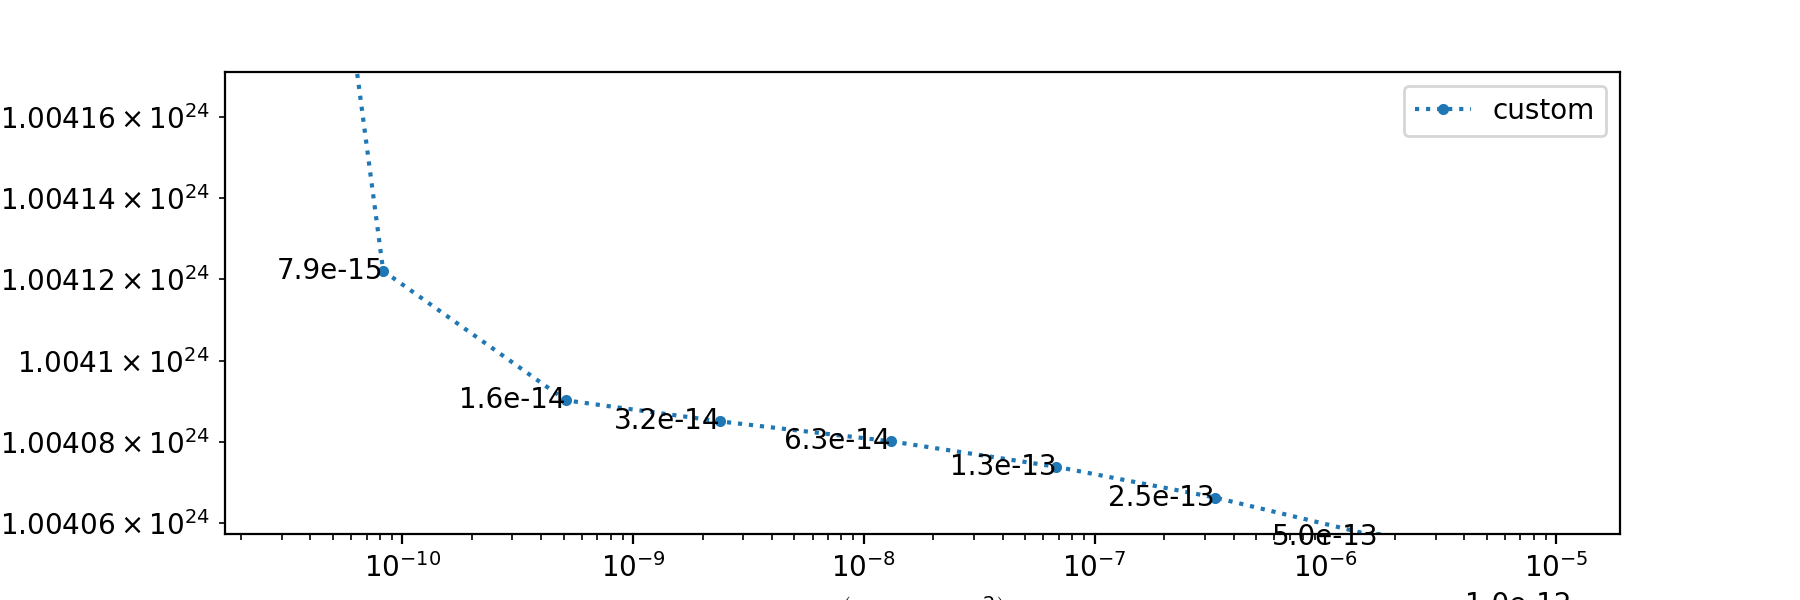

(<Figure size 900x300 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x171e683cd0>)

In [51]:
extra.tikho.l_plot()

In [52]:
f_k = extra.extract(tikhonov=True, tikho_kwargs={'t_mat': tikho_matrix(lam_grid), 'factor': 1.6e-14})

<IPython.core.display.Javascript object>


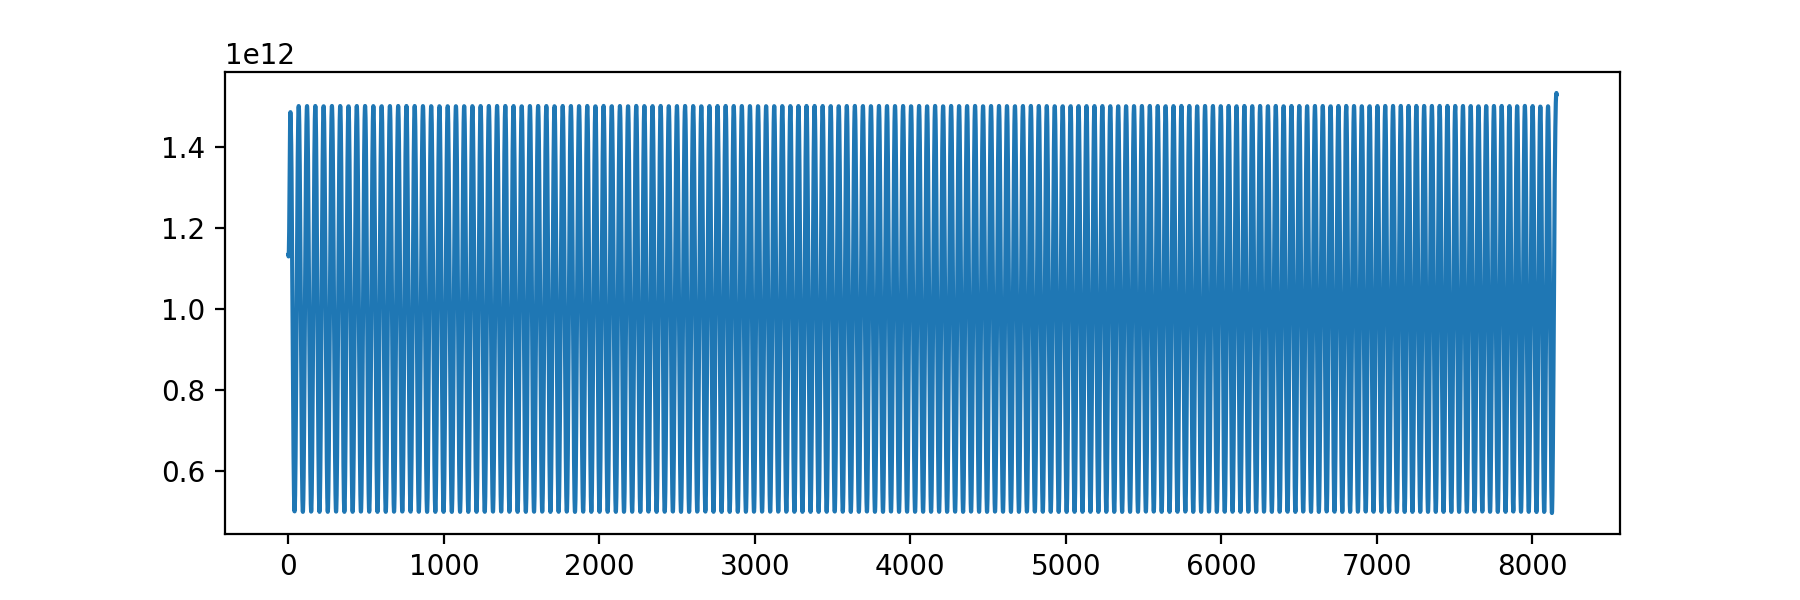

In [53]:
plt.plot(f_k)

### Bin f_k to pixels

In [65]:
from utils import get_lam_p_or_m

In [104]:
def bin_to_pixel(self, i_ord=0, grid_pix=None, grid_f_k=None, f_k_c=None,
                 f_k=None, bounds_error=False, **kwargs):
    """ 
    Integrate f_k_c over a pixel grid using the trapezoidal rule.
    f_k_c is interpolated using scipy.interpolate.interp1d and the 
    kwargs and bounds_error are passed to interp1d.
    grid_pix: tuple of 2 1d-arrays
        arrays of the lower and upper integration ranges
    """
    # Take the value from the order if not given.
    if grid_f_k is None:
        grid_f_k = self.lam_grid_c(i_ord)
    if f_k_c is None:
        if f_k is None:
            raise ValueError("`f_k` or `f_k_c` must be specified.")
        else:
            f_k_c = self.c_list[i_ord].dot(f_k)
    if grid_pix is None:
        wv_map, psf = self.getattrs('lam_list', 'p_list', n=i_ord)
        pix_center = grid_from_map(wv_map, psf)
        grid_pix = get_lam_p_or_m(pix_center)
    else:
        # Compute pixel center
        d_pix = np.diff(grid_pix, axis=0).squeeze()
        pix_center = grid_pix[0] + d_pix
    
    # Interpolate 
    fct_f_k = interp1d(grid_f_k, f_k_c, bounds_error=bounds_error, **kwargs)

    # Intergrate over each bins
    bin_val = []
    for x1, x2 in zip(*grid_pix):
        # Grid points that fall inside the pixel range
        i_grid = (x1 < grid_f_k) & (grid_f_k < x2)
        x_grid = grid_f_k[i_grid]
        # Add boundaries values to the integration grid
        x_grid = np.concatenate([[x1], x_grid, [x2]])
        # Integrate
        bin_val.append(np.trapz(fct_f_k(x_grid), x_grid))

    # Convert to array and return
    return pix_center, np.array(bin_val)

In [136]:
pix_center, bin_val = bin_to_pixel(extra, f_k=f_k, grid_pix=(lam_m, lam_p), kind='linear')

In [137]:
_, bin_val_th = bin_to_pixel(simu, f_k=flux, kind='cubic')

<IPython.core.display.Javascript object>


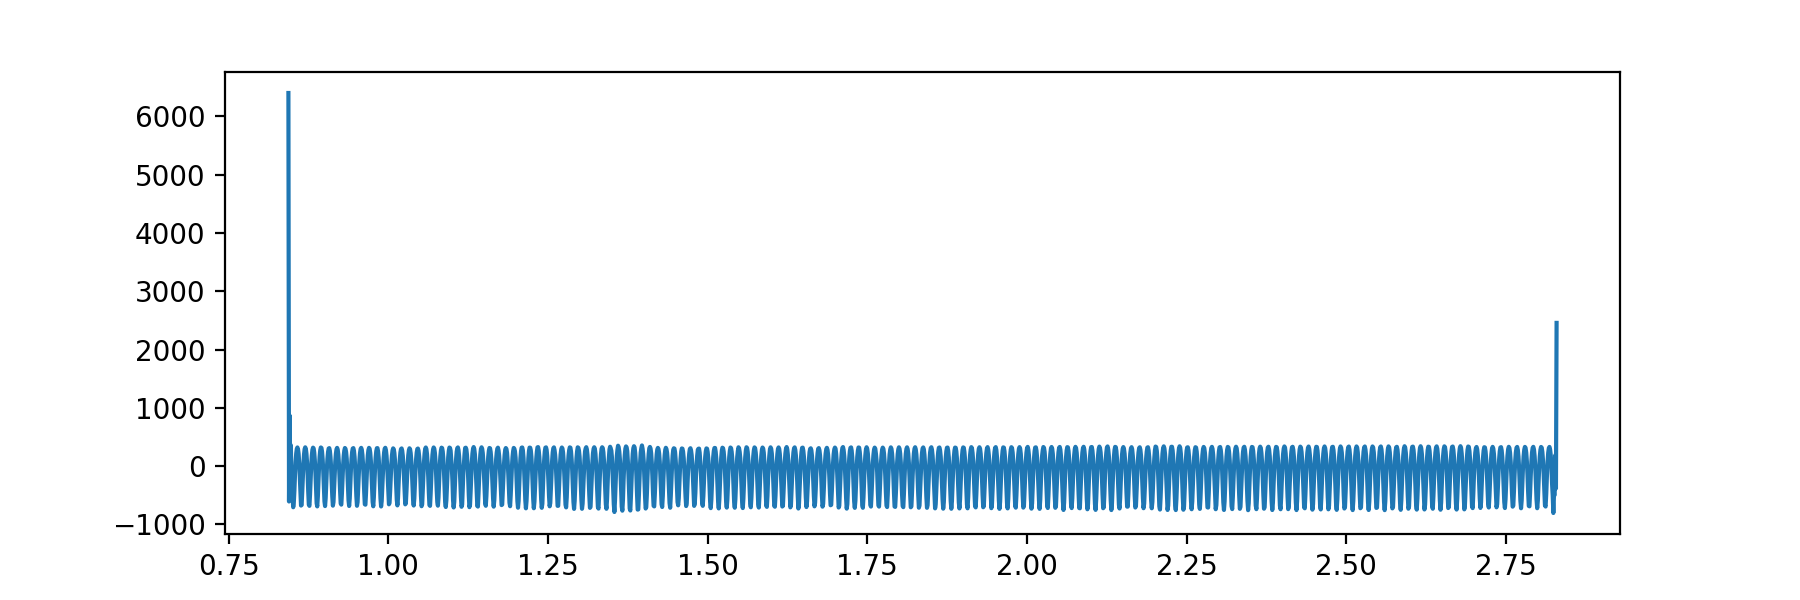

In [138]:
plt.plot(pix_center, (bin_val-bin_val_th)/bin_val_th * 1e6)
# plt.plot(pix_center, bin_val_th)

## Extract with box extraction

In [115]:
def box_extract(data, psf, wv_map, thresh=1e-5):
    i_nan = (psf < thresh)
    data = np.copy(data)
    data[i_nan] = np.nan
    out_box = np.nansum(data, axis=0)
#     
#     lam_grid = 
    
    return out_box

In [119]:
from classic import OptimalExtract

In [122]:
def fct_ones(x): return np.ones_like(x)
box_extra = OptimalExtract(data1, T_ord=fct_ones, P_ord=P1, lam_ord=wv_1)

In [124]:
box_extra.extract()

ValueError: operands could not be broadcast together with shapes (2038,) (2040,) 